If additional cations are included, they may be included as (screened) Coulomb interactions with additional LJ/Buckingham potentials.
ref: https://pubs.rsc.org/en/Content/ArticleLanding/2011/CP/c1cp21034c

Solubility of CO2 is approximately 1g/kg H2O at 300 K, so there is approximately 2500 water molecules per molecule of CO2.

In [1]:
%pylab inline
from mpl_toolkits.mplot3d import Axes3D

from lammpsrun import LAMMPS, Prism
from itertools import product
from utility_scripts import *

from ase import Atoms, units
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io.trajectory import Trajectory
from ase.io import write, read
from ase.utils import natural_cutoffs
from ase.data import vdw_radii, atomic_numbers, covalent_radii

import nglview as nv

home_path = "D:\\Cloud Storage\\GitRepositories\\LAMMPS_Simulation\\"
hpc_path = "G:\\home\\LAMMPS_Simulation\\HPC_Jupyter\\"
print(home_path + "\n" + hpc_path)

D:\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


Populating the interactive namespace from numpy and matplotlib
D:\Cloud Storage\GitRepositories\LAMMPS_Simulation\
G:\home\LAMMPS_Simulation\HPC_Jupyter\


## Visualizing LAMMPS trajectory

In [43]:
H2O_bulk_traj_pos = []

for i in range(0, 1000, 10):
    O_atoms = H2O_bulk_traj[i][[a.index for a in H2O_bulk_traj[i] if a.symbol == 'O']]
    O_pos = O_atoms.positions
    H2O_bulk_traj_pos.append(O_pos)
    
H2O_bulk_traj_pos = array(H2O_bulk_traj_pos)
H2O_bulk_traj_pos_plot = H2O_bulk_traj_pos.transpose(1, 2, 0)

<IPython.core.display.Javascript object>


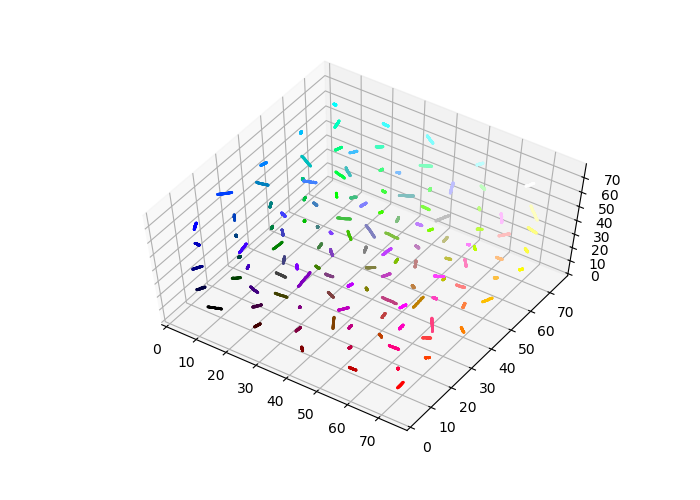

In [18]:
# Plotting individual atom as points

fig = plt.figure(figsize=(7, 5))

ax = fig.add_subplot(111, projection='3d')

C = linspace(0, 255, 5)
C_list = array([list(x) for x in product(C, C, C)])/255

#ax.set_xlabel('Box x-axis')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')
ax.set_xlim(0, box_length*5)
ax.set_ylim(0, box_length*5)
ax.set_zlim(0, box_length*5)

for img in H2O_bulk_traj_pos:
    ax.scatter(img[:,0], img[:,1], img[:,2], c=C_list, s=1)
    
plt.show()

<IPython.core.display.Javascript object>


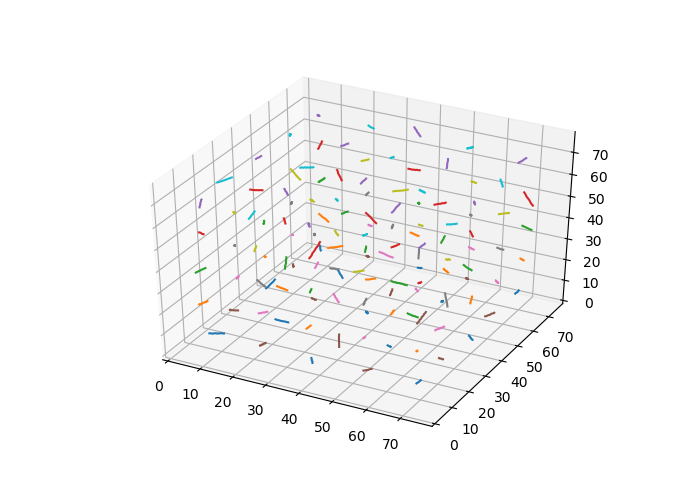

In [19]:
# Plotting individual atoms as lines. The lines crosses the whole simulation box when the particle
# crosses the PBs, not ideal.

fig = plt.figure(figsize=(7, 5))

ax = fig.add_subplot(111, projection='3d')

#ax.set_xlabel('X Label')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')
ax.set_xlim(0, box_length*5)
ax.set_ylim(0, box_length*5)
ax.set_zlim(0, box_length*5)

for a in H2O_bulk_traj_pos_plot:
    ax.plot(a[0], a[1], a[2])

plt.show()

Or we can read-in the previously configured structure.

In [13]:
CO2_solvation_traj = Trajectory(hpc_path + "co2_hydration\\CO2_solvation_300K.traj")

CO2_solvation_traj_view = nv.show_asetraj(CO2_solvation_traj, gui=True)

CO2_solvation_traj_view.player.parameters = dict(delay=150, step=10, scale=0.8)
CO2_solvation_traj_view.remove_ball_and_stick()
CO2_solvation_traj_view.add_spacefill(radiusType='covalent',
                                      scale=1,
                                      color_scheme='element')
CO2_solvation_traj_view

NGLWidget(count=100001)

In [31]:
CO2_solvation_traj.close()

In [ ]:
CO2_solvation_calc = LAMMPS()
CO2_solvation = read(hpc_path + "co2_hydration\\CO2_solvation.extxyz")
CO2_solvation.set_calculator(CO2_solvation_calc)
CO2_solvation_calc.trajectory_out = Trajectory(hpc_path + "co2_hydration\\CO2_solvation.bundle", 'w')
CO2_solvation_calc.read_lammps_trj(lammps_trj = "G:\\home\\cx1_out\\2150320.cx1\\CO2_solvation_300K.lammpstrj")
CO2_solvation_calc.trajectory_out.close()

# 10 CO2 Molecules

In [2]:
CO2_10_aq_traj = Trajectory(hpc_path + "co2_hydration\\CO2_10_aq.traj")

In [3]:
CO2_10_aq_traj_view = nv.show_asetraj(CO2_10_aq_traj, gui=True)

CO2_10_aq_traj_view.player.parameters = dict(delay=150, step=10, scale=0.8)
CO2_10_aq_traj_view.representations = [{"type": "spacefill",
                                        "params": {"sele": "*",
                                                   "scale": "0.2",
                                                   "color": "element",
                                                   "radius": "covalent"}
                                       }]
CO2_10_aq_traj_view

NGLWidget(count=100001)

In [ ]:
CO2_10_aq_calc = LAMMPS()
CO2_10_aq = read(hpc_path + "co2_hydration\\CO2_10_aq.extxyz")
CO2_10_aq.set_calculator(CO2_10_aq_calc)
CO2_10_aq_calc.trajectory_out = Trajectory(hpc_path + "co2_hydration\\CO2_10_aq.traj", 'w')
CO2_10_aq_calc.read_lammps_trj(lammps_trj = "G:\\home\\cx1_out\\2150321.cx1\\CO2_10_aq.lammpstrj")
CO2_10_aq_calc.trajectory_out.close()

In [47]:
all_coord_data = []
cut_off_array = [0.8, 1.0, 1.2]
carbon_indices = [i for i, x in enumerate(CO2_10_aq_traj[0].get_chemical_symbols()) if x == "C"]

for i in range(len(CO2_10_aq_traj)//1000):
    snap = CO2_10_aq_traj[i*100]
    snap.set_pbc(True)
    coord_number_array = [get_coordination_number(snap, carbon_indices, cut_off = i) for i in cut_off_array]
    coord_number_list = list(zip(*coord_number_array))
    all_coord_data.append(coord_number_list)
    
all_coord_data = array(all_coord_data)

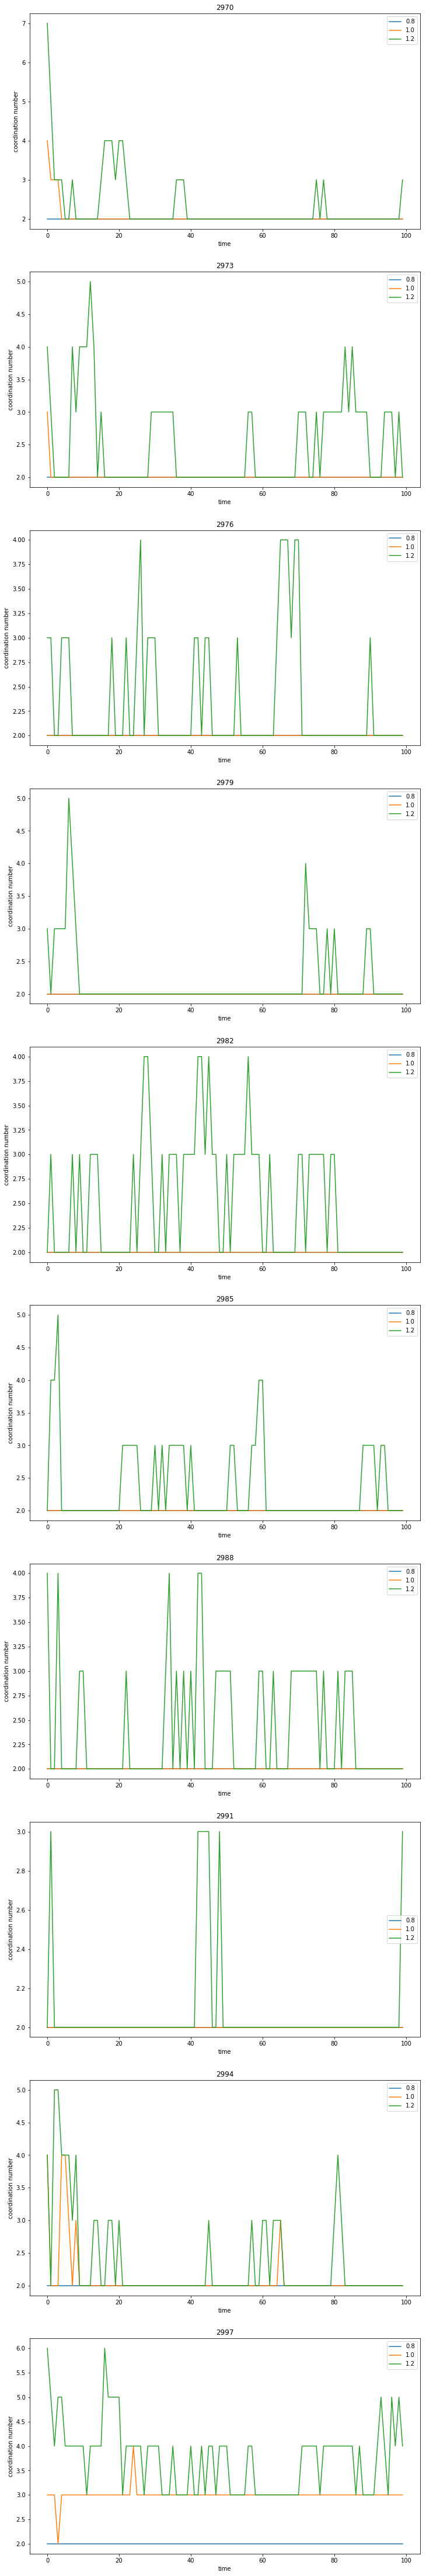

In [48]:
figure(figsize=(12, 80))

for i in range(10):
    subplot(10, 1, i+1)
    plot(range(len(CO2_10_aq_traj)//1000), all_coord_data[:, i, 0], label = '0.8')
    plot(range(len(CO2_10_aq_traj)//1000), all_coord_data[:, i, 1], label = '1.0')
    plot(range(len(CO2_10_aq_traj)//1000), all_coord_data[:, i, 2], label = '1.2')
    legend()
    title(carbon_indices[i])
    xlabel('time')
    ylabel('coordination number')
show()

In [ ]:
CO2_10_aq_traj_pos = []

for i in range(0, 1000, 10):
    O_atoms = H2O_bulk_traj[i][[a.index for a in H2O_bulk_traj[i] if a.symbol == 'O']]
    O_pos = O_atoms.positions
    H2O_bulk_traj_pos.append(O_pos)
    
H2O_bulk_traj_pos = array(H2O_bulk_traj_pos)
H2O_bulk_traj_pos_plot = H2O_bulk_traj_pos.transpose(1, 2, 0)